In [1]:
# [기본 세팅] ------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from IPython.display import display

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 윈도우 한글 폰트 + 마이너스 표시 깨짐 방지
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 표시에 도움되는 옵션 (너무 길게 줄바꿈되는 것 방지)
pd.set_option("display.max_columns", 120)
pd.set_option("display.width", 160)

print("✅ 기본 세팅 완료")

✅ 기본 세팅 완료


In [2]:
# === [번들에서 복원] ===
import pickle

BUNDLE_PATH = "_snapshots/olist_clean_bundle.pkl"

with open(BUNDLE_PATH, "rb") as f:
    bundle = pickle.load(f)

# 변수로 바로 풀어서 사용
orders_clean       = bundle["orders_clean"]
order_items_clean  = bundle["order_items_clean"]
payments_clean     = bundle["payments_clean"]
reviews_clean      = bundle["reviews_clean"]
customers_clean    = bundle["customers_clean"]
geolocation_clean  = bundle["geolocation_clean"]
products_clean     = bundle["products_clean"]
sellers_clean      = bundle["sellers_clean"]
category_tr_clean  = bundle["category_tr_clean"]
rfm =   bundle["rfm"]

print("✅ Restored all *_clean DataFrames")


✅ Restored all *_clean DataFrames


In [3]:
# === 블럭 1) 배송완료 주문 + 리드타임/지연 ===
use_cols = [
    "order_id","customer_id",
    "order_purchase_timestamp",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "order_status"
]

o = orders_clean[use_cols].copy()
# 배송완료 + 핵심 날짜 결측 제거
o = o[o["order_status"]=="delivered"].dropna(subset=[
    "order_purchase_timestamp","order_delivered_customer_date","order_estimated_delivery_date"
])

# 날짜형으로 통일
o["order_purchase_timestamp"]       = pd.to_datetime(o["order_purchase_timestamp"], errors="coerce")
o["order_delivered_carrier_date"]   = pd.to_datetime(o["order_delivered_carrier_date"], errors="coerce")
o["order_delivered_customer_date"]  = pd.to_datetime(o["order_delivered_customer_date"], errors="coerce")
o["order_estimated_delivery_date"]  = pd.to_datetime(o["order_estimated_delivery_date"], errors="coerce")

# 일(day) 단위로 차이 계산
sec_per_day = 86400
o["proc_days"]    = (o["order_delivered_carrier_date"]  - o["order_purchase_timestamp"]).dt.total_seconds()/sec_per_day
o["ship_days"]    = (o["order_delivered_customer_date"] - o["order_delivered_carrier_date"]).dt.total_seconds()/sec_per_day
o["lead_days"]    = (o["order_delivered_customer_date"] - o["order_purchase_timestamp"]).dt.total_seconds()/sec_per_day
o["delay_signed"] = (o["order_delivered_customer_date"] - o["order_estimated_delivery_date"]).dt.total_seconds()/sec_per_day
o["delay_days"]   = o["delay_signed"].clip(lower=0)   # 조기(음수)는 0으로
o["is_late"]      = o["delay_days"] > 0

print("✓ 배송완료 주문 수:", o["order_id"].nunique())
display(o.head(3))


✓ 배송완료 주문 수: 96470


,order_id,customer_id,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_status,proc_days,ship_days,lead_days,delay_signed,delay_days,is_late
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,delivered,2.373924,6.062650,8.436574,-7.107488,0.0,False
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,delivered,1.742627,12.039410,13.782037,-5.355729,0.0,False
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,delivered,0.216100,9.178113,9.394213,-17.245498,0.0,False


In [4]:
# === 블럭 2) 고객 주 + 리뷰 평균 조인 ===
cust = customers_clean[["customer_id","customer_unique_id","customer_state"]].drop_duplicates("customer_id")
o = o.merge(cust, on="customer_id", how="left")

# 주문별 리뷰 평균점수
if "review_score" in reviews_clean.columns:
    r = reviews_clean.copy()
    r["review_score"] = pd.to_numeric(r["review_score"], errors="coerce")
    rev_mean = r.groupby("order_id", as_index=False)["review_score"].mean()
    o = o.merge(rev_mean, on="order_id", how="left")
else:
    o["review_score"] = pd.NA

display(o[["order_id","customer_state","lead_days","delay_days","is_late","review_score"]].head(5))


,order_id,customer_state,lead_days,delay_days,is_late,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,SP,8.436574,0.0,False,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,BA,13.782037,0.0,False,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,GO,9.394213,0.0,False,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,RN,13.208750,0.0,False,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,SP,2.873877,0.0,False,5.0


In [5]:
# === 블럭 3) 주별 KPI ===
state_kpi = (o.groupby("customer_state")
               .agg(
                   orders=("order_id","nunique"),
                   lead_mean=("lead_days","mean"),
                   lead_median=("lead_days","median"),
                   lead_p90=("lead_days", lambda s: s.quantile(0.90)),
                   late_rate=("is_late","mean"),
                   late_days_mean=("delay_days", lambda s: s[s>0].mean()),
                   review_mean=("review_score","mean")
               )
               .reset_index())

# 보기 좋게 반올림/퍼센트
state_kpi["late_rate(%)"] = (state_kpi["late_rate"]*100).round(2)
for c in ["lead_mean","lead_median","lead_p90","late_days_mean","review_mean"]:
    state_kpi[c] = state_kpi[c].round(2)

# TOP 리스트 예시
top_late = state_kpi.sort_values("late_rate(%)", ascending=False).head(10)
top_lead = state_kpi.sort_values("lead_mean",   ascending=False).head(10)
top_vol  = state_kpi.sort_values("orders",      ascending=False).head(10)

print("=== [주별 KPI 상위 20 by 물량] ===")
display(state_kpi.sort_values("orders", ascending=False).head(20))
print("\n[지연율 TOP10]");   display(top_late[["customer_state","orders","late_rate(%)","lead_mean","review_mean"]])
print("\n[리드타임 TOP10]"); display(top_lead[["customer_state","orders","lead_mean","lead_p90","late_rate(%)"]])
print("\n[물량 TOP10]");     display(top_vol [["customer_state","orders","lead_mean","late_rate(%)"]])


=== [주별 KPI 상위 20 by 물량] ===


,customer_state,orders,lead_mean,lead_median,lead_p90,late_rate,late_days_mean,review_mean,late_rate(%)
25,SP,40494,8.76,7.21,15.77,0.058947,7.03,4.25,5.89
18,RJ,12350,15.31,12.04,29.09,0.134737,12.85,3.97,13.47
10,MG,11354,12.01,10.31,20.20,0.056104,7.53,4.19,5.61
22,RS,5344,15.30,13.18,25.88,0.071482,9.41,4.19,7.15
17,PR,4923,11.99,10.43,20.12,0.049970,7.40,4.24,5.00
23,SC,3546,14.95,13.01,25.79,0.097575,7.70,4.13,9.76
4,BA,3256,19.34,16.91,31.81,0.140356,11.10,3.93,14.04
6,DF,2080,12.97,11.36,21.64,0.070673,6.64,4.13,7.07
7,ES,1995,15.79,13.64,25.35,0.122306,10.60,4.08,12.23
8,GO,1957,15.61,13.95,24.84,0.081758,9.79,4.10,8.18



[지연율 TOP10]


,customer_state,orders,late_rate(%),lead_mean,review_mean
1,AL,397,23.93,24.54,3.85
9,MA,717,19.67,21.57,3.83
16,PI,476,15.97,19.46,3.99
5,CE,1279,15.32,21.27,3.94
24,SE,335,15.22,21.52,3.91
4,BA,3256,14.04,19.34,3.93
18,RJ,12350,13.47,15.31,3.97
26,TO,274,12.77,17.66,4.15
13,PA,946,12.37,23.77,3.91
7,ES,1995,12.23,15.79,4.08



[리드타임 TOP10]


,customer_state,orders,lead_mean,lead_p90,late_rate(%)
21,RR,41,29.39,53.19,12.20
3,AP,67,27.19,34.66,4.48
2,AM,145,26.43,39.13,4.14
1,AL,397,24.54,39.45,23.93
13,PA,946,23.77,39.23,12.37
9,MA,717,21.57,34.32,19.67
24,SE,335,21.52,35.46,15.22
5,CE,1279,21.27,34.72,15.32
0,AC,80,21.04,31.08,3.75
14,PB,517,20.43,34.95,11.03



[물량 TOP10]


,customer_state,orders,lead_mean,late_rate(%)
25,SP,40494,8.76,5.89
18,RJ,12350,15.31,13.47
10,MG,11354,12.01,5.61
22,RS,5344,15.30,7.15
17,PR,4923,11.99,5.00
23,SC,3546,14.95,9.76
4,BA,3256,19.34,14.04
6,DF,2080,12.97,7.07
7,ES,1995,15.79,12.23
8,GO,1957,15.61,8.18


In [6]:
# === 블럭 4) 월별 추이 테이블 ===
o["order_month"] = o["order_purchase_timestamp"].dt.to_period("M").dt.to_timestamp()

monthly_kpi = (o.groupby("order_month")
                 .agg(orders=("order_id","nunique"),
                      lead_mean=("lead_days","mean"),
                      late_rate=("is_late","mean"))
                 .reset_index())

monthly_kpi["lead_mean"]   = monthly_kpi["lead_mean"].round(2)
monthly_kpi["late_rate(%)"] = (monthly_kpi["late_rate"]*100).round(2)

print("=== [월별 추이(표)] ===")
display(monthly_kpi.head(12))


=== [월별 추이(표)] ===


,order_month,orders,lead_mean,late_rate,late_rate(%)
0,2016-09-01,1,54.81,1.000000,100.00
1,2016-10-01,265,19.60,0.011321,1.13
2,2016-12-01,1,4.69,0.000000,0.00
3,2017-01-01,750,12.65,0.030667,3.07
4,2017-02-01,1653,13.17,0.032063,3.21
5,2017-03-01,2546,12.95,0.055774,5.58
6,2017-04-01,2303,14.92,0.078593,7.86
7,2017-05-01,3545,11.32,0.036107,3.61
8,2017-06-01,3135,12.01,0.038596,3.86
9,2017-07-01,3872,11.59,0.034349,3.43


In [7]:
# === 블럭 5) 지연 구간(bucket) + 리뷰 ===
def delay_bucket(x):
    if x <= 0:  return "정시/조기"
    if x <= 3:  return "1-3일 지연"
    if x <= 7:  return "4-7일 지연"
    return "7일초과 지연"

o["delay_bucket"] = o["delay_signed"].apply(delay_bucket)

delay_bins_kpi = (o.groupby("delay_bucket")
                    .agg(orders=("order_id","nunique"),
                         review_mean=("review_score","mean"),
                         low_rate=("review_score", lambda s: (s<=3).mean()))
                    .reset_index())

delay_bins_kpi["review_mean"] = delay_bins_kpi["review_mean"].round(2)
delay_bins_kpi["low_rate(%)"] = (delay_bins_kpi["low_rate"]*100).round(2)

print("=== [지연 구간별 리뷰 반응] ===")
display(delay_bins_kpi)


=== [지연 구간별 리뷰 반응] ===


,delay_bucket,orders,review_mean,low_rate,low_rate(%)
0,1-3일 지연,2662,3.77,0.333208,33.32
1,4-7일 지연,1819,2.32,0.702584,70.26
2,7일초과 지연,3345,1.73,0.850523,85.05
3,정시/조기,88644,4.29,0.171145,17.11


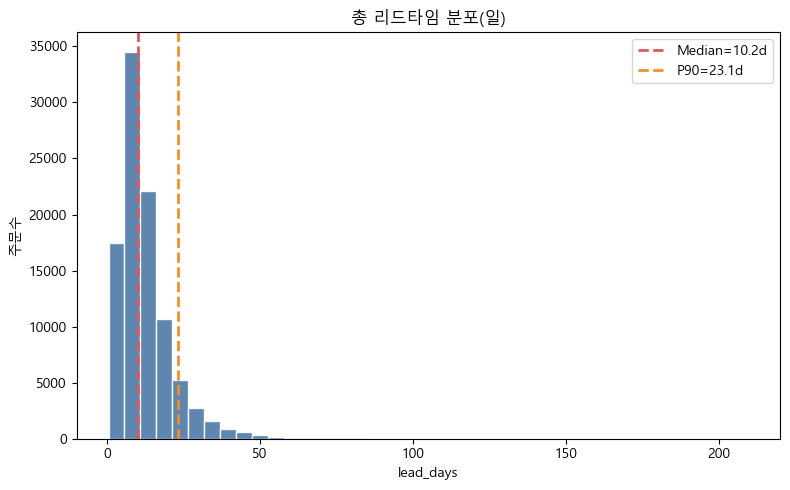

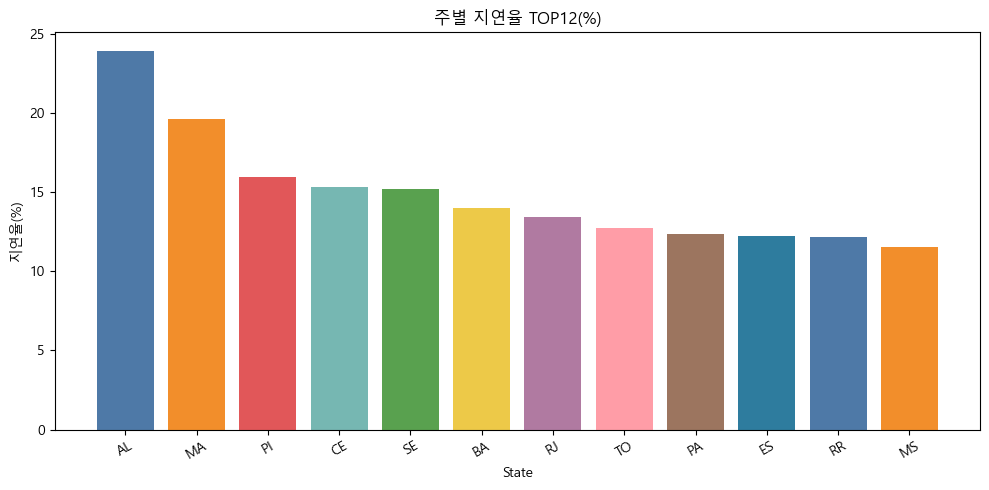

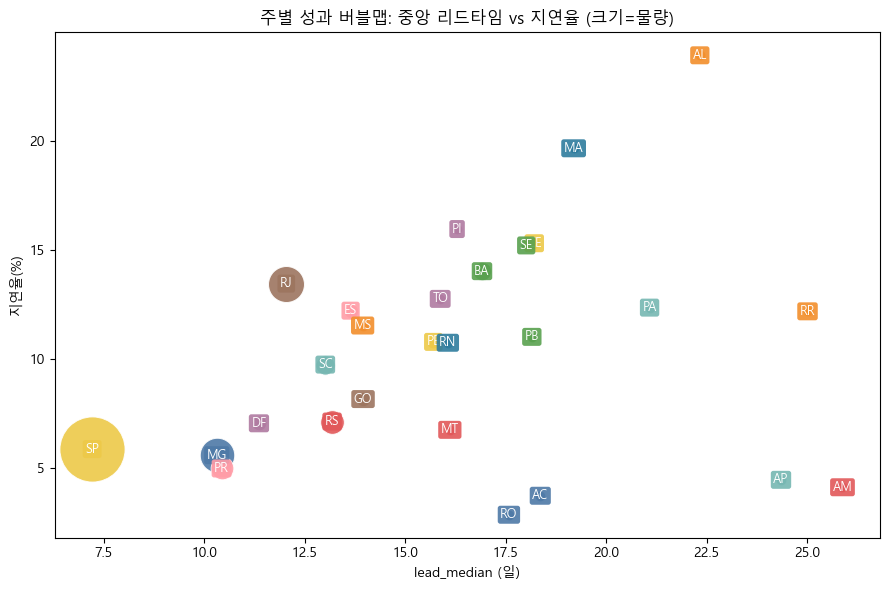

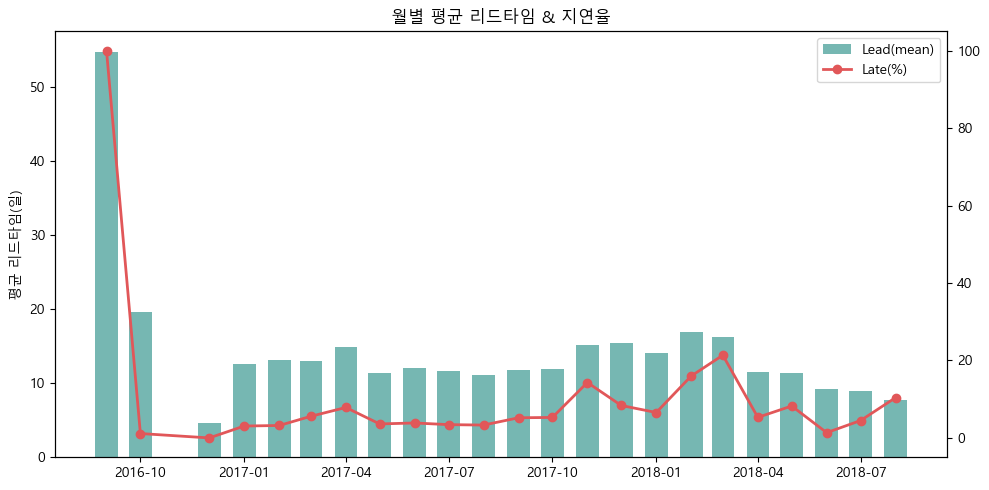

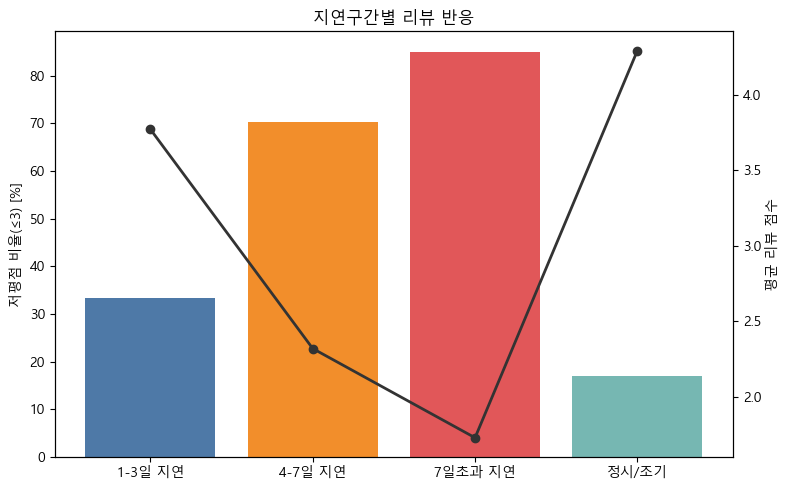

In [8]:
# === 블럭 6 : 시각화 (알록달록 팔레트 + 버블맵 복원 + 3M MA 유지) ===

# --- 공통 팔레트(알록달록) ---
COLORS = ["#4E79A7","#F28E2B","#E15759","#76B7B2","#59A14F",
          "#EDC948","#B07AA1","#FF9DA7","#9C755F","#2E7C9E"]

# --- 월별 3M 이동평균 컬럼이 없으면 여기서 계산(안전장치) ---
monthly_kpi = monthly_kpi.sort_values("order_month").reset_index(drop=True).copy()

if "lead_ma3" not in monthly_kpi.columns:
    monthly_kpi["lead_ma3"] = monthly_kpi["lead_mean"].rolling(3, min_periods=1).mean().round(2)

# late_rate 소스가 'late_rate' 혹은 'late_rate(%)' 중 무엇인지 확인
if "late_ma3(%)" not in monthly_kpi.columns:
    if "late_rate" in monthly_kpi.columns:
        monthly_kpi["late_ma3(%)"] = (monthly_kpi["late_rate"].rolling(3, min_periods=1).mean()*100).round(2)
    elif "late_rate(%)" in monthly_kpi.columns:
        monthly_kpi["late_ma3(%)"] = monthly_kpi["late_rate(%)"].rolling(3, min_periods=1).mean().round(2)
    else:
        # 없으면 0으로 채움(표시만)
        monthly_kpi["late_ma3(%)"] = 0.0

# -----------------------------
# (A) 총 리드타임 분포 히스토그램
# -----------------------------
plt.figure(figsize=(8,5))
vals = o["lead_days"].dropna()
plt.hist(vals, bins=40, color=COLORS[0], alpha=0.9, edgecolor="white")
med, p90 = float(vals.median()), float(vals.quantile(0.90))
plt.axvline(med, color=COLORS[2], linestyle="--", linewidth=2, label=f"Median={med:.1f}d")
plt.axvline(p90, color=COLORS[1], linestyle="--", linewidth=2, label=f"P90={p90:.1f}d")
plt.title("총 리드타임 분포(일)")
plt.xlabel("lead_days"); plt.ylabel("주문수")
plt.legend(); plt.tight_layout(); plt.show()

# -----------------------------
# (B) 주별 지연율 TOP 12 바 (알록달록)
# -----------------------------
top12 = state_kpi.sort_values("late_rate(%)", ascending=False).head(12).copy()
plt.figure(figsize=(10,5))
plt.bar(top12["customer_state"], top12["late_rate(%)"], color=COLORS[:len(top12)])
plt.title("주별 지연율 TOP12(%)"); plt.xlabel("State"); plt.ylabel("지연율(%)")
plt.xticks(rotation=30); plt.tight_layout(); plt.show()

# -----------------------------
# (C) 주별 성과 버블맵 (복원)
#   - x: 중앙 리드타임(일)
#   - y: 지연율(%)
#   - s: 주문 물량(상대 크기)
#   - 색: 팔레트 순환
# -----------------------------
plt.figure(figsize=(9,6))
# 버블 크기(물량 비례 → [60, 2200] 범위로 클리핑)
size_scale = (state_kpi["orders"] / state_kpi["orders"].max()).replace([np.inf, -np.inf], np.nan).fillna(0)
sizes = (size_scale * 2200).clip(60, 2200).values

for i, r in state_kpi.reset_index(drop=True).iterrows():
    c = COLORS[i % len(COLORS)]
    plt.scatter(r["lead_median"], r["late_rate(%)"], s=sizes[i],
                color=c, alpha=0.9, edgecolor="white", linewidth=0.7)
    # 라벨을 버블 중앙에 흰 글씨로
    plt.text(r["lead_median"], r["late_rate(%)"], str(r["customer_state"]),
             ha="center", va="center", fontsize=9, color="white",
             bbox=dict(boxstyle="round,pad=0.2", fc=c, ec="none", alpha=0.9))
plt.title("주별 성과 버블맵: 중앙 리드타임 vs 지연율 (크기=물량)")
plt.xlabel("lead_median (일)"); plt.ylabel("지연율(%)")
plt.tight_layout(); plt.show()

# -----------------------------
# (D) 월별 추이: 막대(리드타임) + 선(지연율)
# -----------------------------
plt.figure(figsize=(10,5))
ax = plt.gca()

# 막대: 월별 평균 리드타임
ax.bar(monthly_kpi["order_month"], monthly_kpi["lead_mean"],
       color=COLORS[3], width=20, label="Lead(mean)")
ax.set_ylabel("평균 리드타임(일)")

# 선(우축): 월별 지연율(%)
ax2 = ax.twinx()
# 원 시계열
if "late_rate(%)" in monthly_kpi.columns:
    ax2.plot(monthly_kpi["order_month"], monthly_kpi["late_rate(%)"],
             color=COLORS[2], linewidth=2, marker="o", label="Late(%)")
else:
    # 퍼센트가 없고 late_rate(0~1)만 있으면 변환
    ax2.plot(monthly_kpi["order_month"], monthly_kpi["late_rate"]*100,
             color=COLORS[2], linewidth=2, marker="o", label="Late(%)")

# 범례 합치기
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper right")

plt.title("월별 평균 리드타임 & 지연율")
plt.tight_layout(); plt.show()

# -----------------------------
# (E) 지연구간별 리뷰: 막대(저평점%) + 선(평균점수)
# -----------------------------
x = delay_bins_kpi["delay_bucket"]
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.bar(x, delay_bins_kpi["low_rate(%)"], color=COLORS[:len(x)])
ax.set_ylabel("저평점 비율(≤3) [%]")
ax2 = ax.twinx()
ax2.plot(x, delay_bins_kpi["review_mean"], color="#333333", marker="o", linewidth=2)
ax2.set_ylabel("평균 리뷰 점수")
plt.title("지연구간별 리뷰 반응")
plt.tight_layout(); plt.show()


In [9]:
# === 블럭 7) 핵심 요약 ===
def line(k, v): print(f"- {k}: {v}")

print("\n=== 핵심 요약 ===")
line("전체 평균 리드타임(일)", round(o["lead_days"].mean(), 2))
line("P90(일)", round(o["lead_days"].quantile(0.90), 2))
line("전체 지연율(%)", round(o["is_late"].mean()*100, 2))

# (선택) 지연↔리뷰 상관(참고용)
if pd.api.types.is_numeric_dtype(o["review_score"]):
    corr = pd.Series(o["delay_signed"]).corr(pd.Series(o["review_score"]))
    line("지연(서명)↔리뷰 상관계수", round(corr, 3))

line("지연율 높은 주 TOP3", ", ".join(state_kpi.sort_values("late_rate(%)", ascending=False).head(3)["customer_state"]))
line("물량 많은 주 TOP3", ", ".join(state_kpi.sort_values("orders", ascending=False).head(3)["customer_state"]))



=== 핵심 요약 ===
- 전체 평균 리드타임(일): 12.56
- P90(일): 23.1
- 전체 지연율(%): 8.11
- 지연(서명)↔리뷰 상관계수: -0.267
- 지연율 높은 주 TOP3: AL, MA, PI
- 물량 많은 주 TOP3: SP, RJ, MG


# 지역별 배송 성과 차이를 파악하여 물류 최적화 방안을 도출하세요.

In [10]:
%pip install geopandas pyproj shapely fiona requests --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
# === 블럭 0) 준비: 라이브러리 & 가드 ===
import os
import io
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# (선택) 지도 전용: geopandas (폴리곤 로드/플롯에 편리)
# !pip install geopandas pyproj shapely fiona requests -quiet

import requests
import geopandas as gpd
from shapely.geometry import Point

need = {"customers_clean", "geolocation_clean", "rfm"}
missing = [x for x in need if x not in globals()]
if missing:
    raise NameError(f"다음 DF가 필요합니다: {missing}")

# 상위 세그먼트
TOP_SEG = ["VVIP", "VIP", "고액고객"]


In [12]:
# === 블럭 1) 고객 ZIP→위경도 평균 매핑 + VIP 고객 좌표 ===

# 1) 지오테이블: zip prefix별 평균 좌표 만들기
geo_avg = (geolocation_clean
           .groupby("geolocation_zip_code_prefix")[["geolocation_lat","geolocation_lng"]]
           .mean()
           .rename(columns={"geolocation_lat":"lat","geolocation_lng":"lng"})
           .reset_index())

# 2) 고객 테이블에 좌표 붙이기
cust_geo = customers_clean[["customer_id","customer_unique_id","customer_zip_code_prefix","customer_state"]].copy()
cust_geo = cust_geo.merge(
    geo_avg, left_on="customer_zip_code_prefix", right_on="geolocation_zip_code_prefix", how="left"
).drop(columns=["geolocation_zip_code_prefix"])
cust_geo = cust_geo.dropna(subset=["lat","lng"]).copy()

# 3) VIP/VVIP/고액고객만 필터
vip_uids = rfm[rfm["Segment"].isin(TOP_SEG)]["customer_unique_id"].dropna().unique()
vip_geo = cust_geo[cust_geo["customer_unique_id"].isin(vip_uids)].copy()

print("✓ 좌표 매핑 고객수:", cust_geo["customer_unique_id"].nunique())
print("✓ VIP/VVIP/고액고객(좌표 보유) 수:", vip_geo["customer_unique_id"].nunique())
vip_geo.head(3)


✓ 좌표 매핑 고객수: 95828
✓ VIP/VVIP/고액고객(좌표 보유) 수: 28939


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_state,lat,lng
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,SP,-23.727992,-46.542848
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,SP,-22.975100,-47.142925
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,SP,-23.584221,-46.674053


In [14]:
# === 블럭 2) 브라질 주 경계(NE Admin-1) 다운로드 & 로드 ===
DATA_DIR = "_maps"
os.makedirs(DATA_DIR, exist_ok=True)
NE_ZIP = os.path.join(DATA_DIR, "ne_50m_admin_1_states_provinces.zip")

# 많이 쓰는 공식 미러 경로들(순차 시도)
CANDIDATE_URLS = [
    # Natural Earth 공식 CDN (naciscdn)
    "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_1_states_provinces.zip",
    # 구(舊) 공식 경로(리다이렉트 될 수 있음)
    "https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/cultural/ne_50m_admin_1_states_provinces.zip",
]

def _download_if_needed(urls, out_path):
    if os.path.exists(out_path):
        return out_path
    last_err = None
    for u in urls:
        try:
            r = requests.get(u, timeout=60)
            r.raise_for_status()
            with open(out_path, "wb") as f:
                f.write(r.content)
            return out_path
        except Exception as e:
            last_err = e
    raise RuntimeError(f"Natural Earth 다운로드 실패: {last_err}")

# 1) ZIP 다운로드
try:
    _download_if_needed(CANDIDATE_URLS, NE_ZIP)
    print("✓ Natural Earth Admin-1 ZIP 다운로드 완료:", NE_ZIP)
except Exception as e:
    print("⚠️ 자동 다운로드 실패. 아래 공식 페이지에서 수동으로 내려받아 주세요:")
    print(" - 50m Admin-1 states/provinces:", "https://www.naturalearthdata.com/downloads/50m-cultural-vectors/10m-admin-1-states-provinces/")
    print("   ZIP을", NE_ZIP, "로 저장한 뒤 다시 실행하세요.")
    raise

# 2) GeoDataFrame 로드 (zip 내부 셰이프파일 자동 인식)
gdf_admin1 = gpd.read_file(f"zip://{NE_ZIP}")

# 3) 브라질만 필터 (adm0_a3 == 'BRA' 또는 admin == 'Brazil')
if "adm0_a3" in gdf_admin1.columns:
    gdf_br_states = gdf_admin1[gdf_admin1["adm0_a3"] == "BRA"].copy()
else:
    gdf_br_states = gdf_admin1[gdf_admin1["admin"].str.contains("Brazil", case=False, na=False)].copy()

# 좌표계 확인/설정 (대부분 WGS84)
if gdf_br_states.crs is None:
    gdf_br_states.set_crs(epsg=4326, inplace=True)
elif gdf_br_states.crs.to_epsg() != 4326:
    gdf_br_states = gdf_br_states.to_crs(epsg=4326)

print("✓ 브라질 주 폴리곤 수:", len(gdf_br_states))
gdf_br_states.head(2)


✓ Natural Earth Admin-1 ZIP 다운로드 완료: _maps\ne_50m_admin_1_states_provinces.zip
✓ 브라질 주 폴리곤 수: 27


,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,name_local,type,type_en,code_local,code_hasc,note,hasc_maybe,region,region_cod,provnum_ne,gadm_level,check_me,datarank,abbrev,postal,area_sqkm,sameascity,labelrank,name_len,mapcolor9,mapcolor13,fips,fips_alt,woe_id,woe_label,woe_name,latitude,longitude,sov_a3,adm0_a3,adm0_label,admin,geonunit,gu_a3,gn_id,gn_name,gns_id,gns_name,gn_level,gn_region,gn_a1_code,region_sub,sub_code,gns_level,gns_lang,gns_adm1,gns_region,min_label,max_label,min_zoom,...,name_bn,name_de,name_en,name_es,name_fr,name_el,name_hi,name_hu,name_id,name_it,name_ja,name_ko,name_nl,name_pl,name_pt,name_ru,name_sv,name_tr,name_vi,name_zh,ne_id,name_he,name_uk,name_ur,name_fa,name_zht,FCLASS_ISO,FCLASS_US,FCLASS_FR,FCLASS_RU,FCLASS_ES,FCLASS_CN,FCLASS_TW,FCLASS_IN,FCLASS_NP,FCLASS_PK,FCLASS_DE,FCLASS_GB,FCLASS_BR,FCLASS_IL,FCLASS_PS,FCLASS_SA,FCLASS_EG,FCLASS_MA,FCLASS_PT,FCLASS_AR,FCLASS_JP,FCLASS_KO,FCLASS_VN,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
9,Admin-1 scale rank,2,BRA-576,576,BR-AC,None,BR,1,Acre,None,None,Estado,State,None,BR.AC,None,BR.AC|BRA-ACR,None,None,24.0,1,20,1,Acre,AC,0.0,-99,2,4,5,7,BR01,None,2344844.0,"Acre, BR, Brazil",Acre,-8.9285,-70.2976,BRA,BRA,2,Brazil,Brazil,BRA,3665474,Estado do Acre,-623025.0,"Acre, Estado do",1.0,None,BR.01,None,None,1.0,por,BR01,None,3.7,8.5,3.0,...,একর,Acre,Acre,Estado de Acre,Acre,Άκρε,आक्री,Acre,Acre,Acre,アクレ州,아크리,Acre,Acre,Acre,Акри,Acre,Acre,Acre,阿克里州,1159310053,אקרי,Акрі,اکری,اکری,阿克里州,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-66.62767 -9.92547, -66.73004 -9.975..."
10,Admin-1 scale rank,2,BRA-595,595,BR-RO,None,BR,1,Rondônia,Guaporé,None,Estado,State,None,BR.RO,None,BR.RO|BRA-RND,None,None,24.0,1,20,1,Rond.,RO,0.0,-99,2,8,5,7,BR24,None,2344865.0,"Rondonia, BR, Brazil",Rondônia,-10.9712,-63.1439,BRA,BRA,2,Brazil,Brazil,BRA,3924825,Estado de Rondonia,-667025.0,"Rondonia, Estado de",1.0,None,BR.24,Guaporé,None,1.0,kor,BR24,None,3.7,8.5,3.0,...,রন্ডোনিয়া,Rondônia,Rondônia,Rondônia,Rondônia,Ροντόνια,रोन्डोनिया,Rondônia,Rondônia,Rondônia,ロンドニア州,혼도니아,Rondônia,Rondônia,Rondônia,Рондония,Rondônia,Rondônia,Rondônia,朗多尼亚州,1159307983,רונדוניה,Рондонія,روندونیا,روندونیا,朗多尼亚州,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"POLYGON ((-66.62767 -9.92547, -66.62767 -9.925..."


In [15]:
# === 블럭 3) VIP 좌표를 포인트 지오데이터로 변환 ===
vip_points = gpd.GeoDataFrame(
    vip_geo,
    geometry=gpd.points_from_xy(vip_geo["lng"], vip_geo["lat"]),
    crs="EPSG:4326"
)

print("✓ VIP 포인트 수:", len(vip_points))
vip_points.head(2)


✓ VIP 포인트 수: 31068


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_state,lat,lng,geometry
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,SP,-23.727992,-46.542848,POINT (-46.54285 -23.72799)
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,SP,-22.975100,-47.142925,POINT (-47.14293 -22.9751)


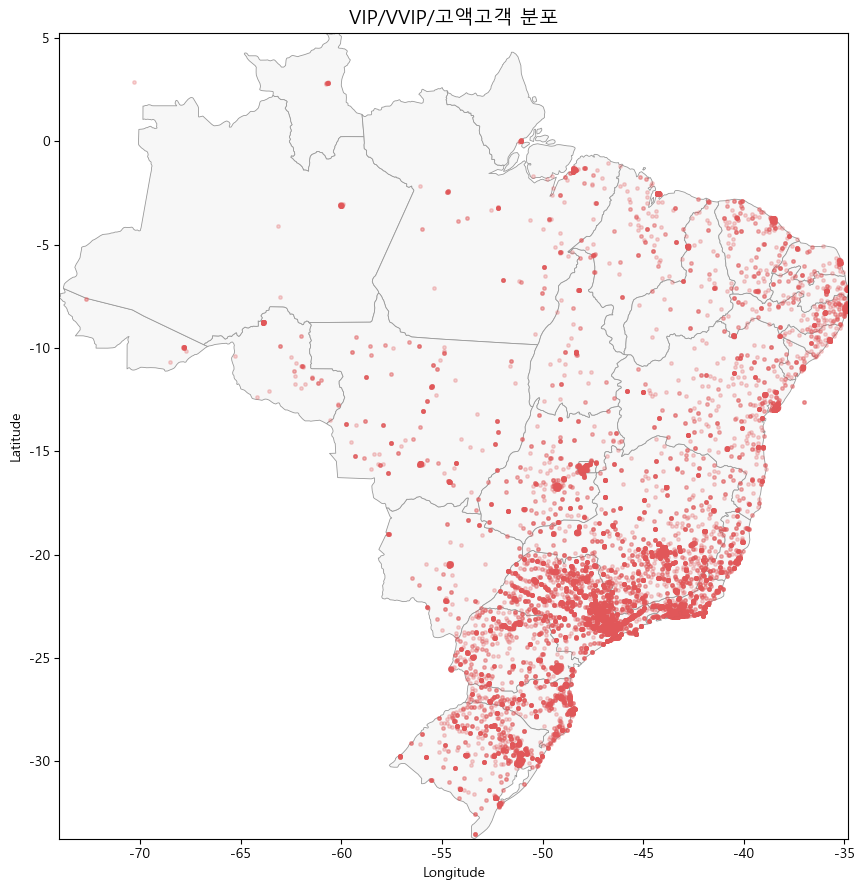

In [17]:
# === 블럭 4) 브라질 지도(주 경계) + VIP 산점도 ===

fig, ax = plt.subplots(figsize=(9,9))

# 1) 브라질 주 경계(배경)
gdf_br_states.plot(ax=ax, facecolor="#F7F7F7", edgecolor="#999999", linewidth=0.6)

# 2) VIP 포인트(투명도↑, 작은 점)
vip_points.plot(ax=ax, markersize=6, alpha=0.25, color="#E15759")  # 붉은 점(겹칠수록 진해짐)

# 3) 축/레이블/타이틀
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("VIP/VVIP/고액고객 분포", fontsize=14)

# 4) 범위(브라질 경계에 맞춤)
ax.set_xlim(gdf_br_states.total_bounds[0], gdf_br_states.total_bounds[2])
ax.set_ylim(gdf_br_states.total_bounds[1], gdf_br_states.total_bounds[3])

plt.tight_layout()
plt.show()


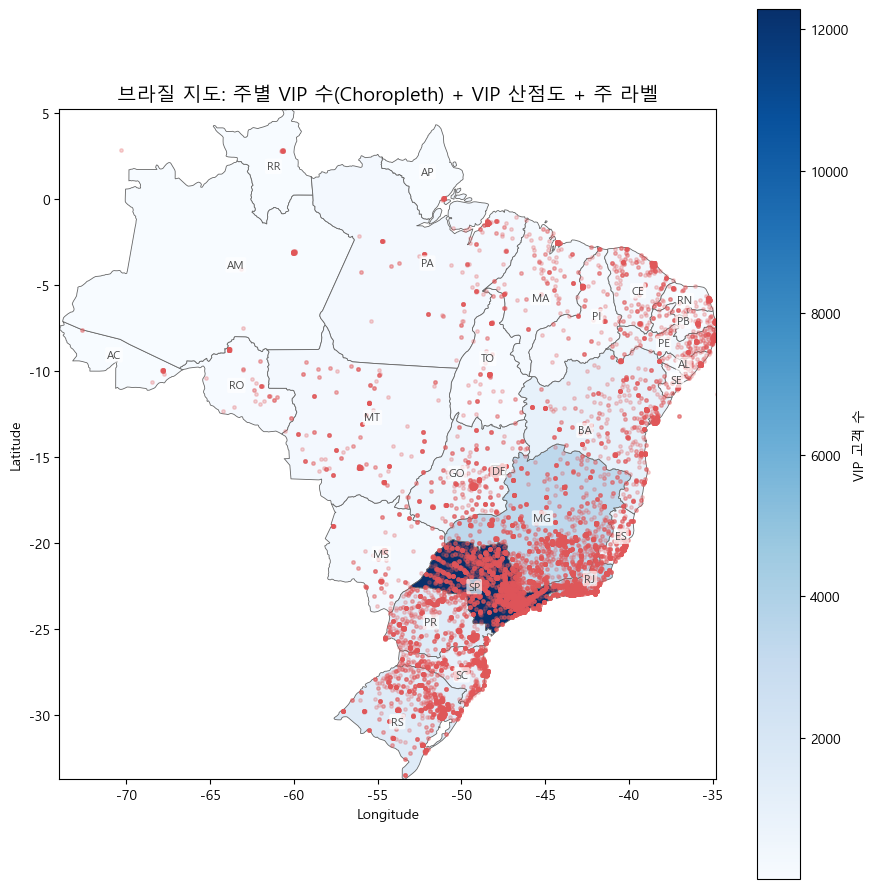

In [33]:
# === 블럭 4AB) 주 라벨 + 주별 VIP Choropleth + VIP 산점도 (합본) ===
# 필요 변수: gdf_br_states, vip_points(GeoDataFrame), vip_geo(DataFrame: customer_state 포함)
import matplotlib.pyplot as plt
import pandas as pd

# --- 0) 가드 ---
need = {"gdf_br_states", "vip_points", "vip_geo"}
missing = [x for x in need if x not in globals()]
if missing:
    raise NameError(f"아래 변수가 필요합니다: {missing}")

# --- 1) 주별 VIP 고객 수 집계 ---
vip_state_cnt = (vip_geo.groupby("customer_state")["customer_unique_id"]
                 .nunique().rename("vip_cnt").reset_index())

# --- 2) Choropleth용 조인 (NE admin-1의 'postal'이 BRA 주 약어일 가능성 높음) ---
if "postal" in gdf_br_states.columns:
    gdf_br_choro = gdf_br_states.merge(
        vip_state_cnt, left_on="postal", right_on="customer_state", how="left"
    ).fillna({"vip_cnt": 0})
    label_col = "postal"  # 라벨도 postal 우선
else:
    # postal이 없으면 일단 조인은 생략(배경만 그리고 산점도+라벨만)
    gdf_br_choro = gdf_br_states.copy()
    gdf_br_choro["vip_cnt"] = 0
    # 라벨 후보
    label_col = "name" if "name" in gdf_br_states.columns else (
        "name_en" if "name_en" in gdf_br_states.columns else None
    )
    print("⚠️ 'postal' 컬럼이 없어 Choropleth는 값이 0으로 표시됩니다. (라벨만 표시)")

# --- 3) 그림 준비 ---
fig, ax = plt.subplots(figsize=(9,9))

# (배경) Choropleth (vip_cnt 값이 있으면 색으로 표현, 없으면 라이트 그레이)
if gdf_br_choro["vip_cnt"].sum() > 0:
    gdf_br_choro.plot(
        ax=ax, column="vip_cnt", cmap="Blues", legend=True,
        legend_kwds={"label":"VIP 고객 수"},
        edgecolor="#666666", linewidth=0.6
    )
else:
    gdf_br_choro.plot(ax=ax, facecolor="#F7F7F7", edgecolor="#666666", linewidth=0.6)

# (오버레이) VIP 산점도 — 투명도↑ (겹칠수록 진해짐)
vip_points.plot(ax=ax, markersize=6, alpha=0.25, color="#E15759", label="VIP Points")

# (라벨) 주 약어/이름을 폴리곤 내부 대표점 위치에 표시
if label_col is not None and label_col in gdf_br_states.columns:
    reps = gdf_br_states.representative_point()
    for (x, y), lab in zip(reps.geometry.apply(lambda p: (p.x, p.y)),
                           gdf_br_states[label_col].fillna("")):
        ax.text(x, y, str(lab), ha="center", va="center", fontsize=8, color="#444444",
                bbox=dict(boxstyle="round,pad=0.15", fc="#ffffff", ec="none", alpha=0.7))

# (제목/축/범위)
ax.set_title("브라질 지도: 주별 VIP 수(Choropleth) + VIP 산점도 + 주 라벨", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
minx, miny, maxx, maxy = gdf_br_states.total_bounds
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
plt.tight_layout(); plt.show()


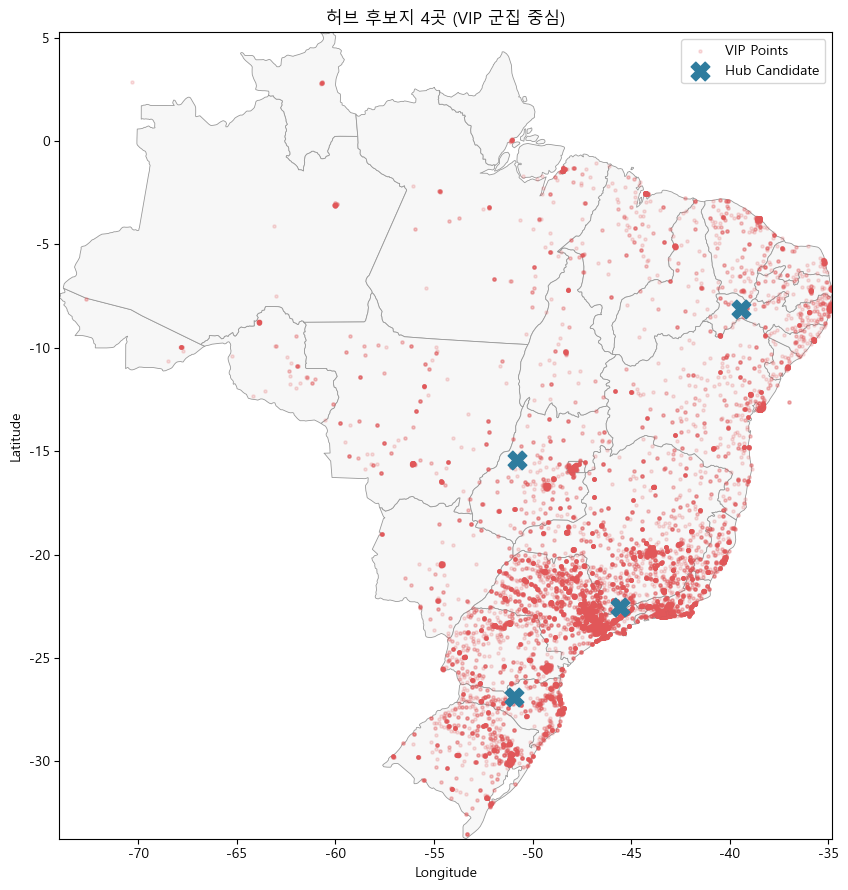

In [22]:
# === 블럭 6) (선택) 허브 후보: K-means 중심을 마커로 ===
from sklearn.cluster import KMeans

pts = vip_points[["lat","lng"]].dropna().to_numpy()
K = 4  # 후보 허브 개수 가정 (원하는 수로 바꾸세요)

if len(pts) >= K:
    km = KMeans(n_clusters=K, n_init=10, random_state=42)
    km.fit(pts[:, :2])  # [lat, lng]
    centers = km.cluster_centers_
    hubs = pd.DataFrame(centers, columns=["lat","lng"])
    hubs_gdf = gpd.GeoDataFrame(hubs, geometry=gpd.points_from_xy(hubs["lng"], hubs["lat"]), crs="EPSG:4326")

    fig, ax = plt.subplots(figsize=(9,9))
    gdf_br_states.plot(ax=ax, facecolor="#F7F7F7", edgecolor="#999999", linewidth=0.6)
    vip_points.plot(ax=ax, markersize=5, alpha=0.18, color="#E15759", label="VIP Points")

    # 허브(X 마커)
    hubs_gdf.plot(ax=ax, color="#2E7C9E", markersize=180, marker="X", label="Hub Candidate")

    ax.set_title(f"허브 후보지 {K}곳 (VIP 군집 중심)")
    ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
    ax.set_xlim(gdf_br_states.total_bounds[0], gdf_br_states.total_bounds[2])
    ax.set_ylim(gdf_br_states.total_bounds[1], gdf_br_states.total_bounds[3])
    ax.legend(loc="upper right")
    plt.tight_layout(); plt.show()
else:
    print("K-means 생략: VIP 포인트가 K보다 적습니다.")


✓ 기존 hubs_gdf 사용


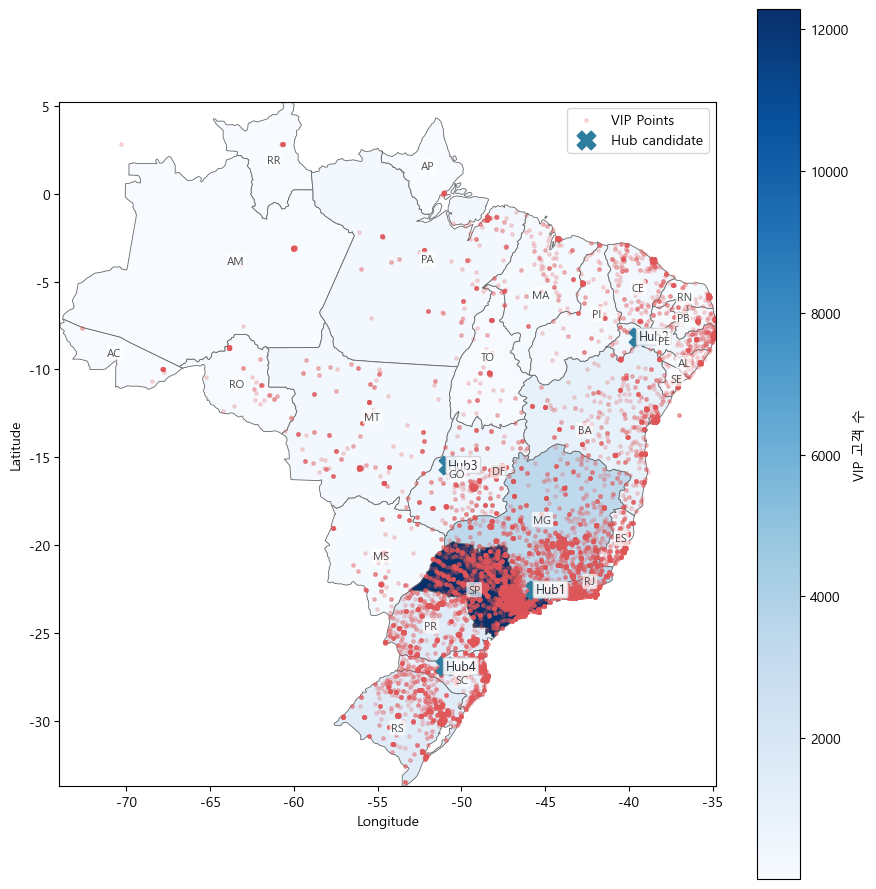

In [41]:
# === 블럭 6′) 허브 후보(X 마커) 오버레이 (4AB와 같은 스타일) ===

# --- 1) 허브 후보 좌표 확보 ---
# 1) hubs_gdf(GeoDataFrame)가 이미 있으면 그대로 사용
if "hubs_gdf" in globals():
    hubs_plot = hubs_gdf.copy()
    print("✓ 기존 hubs_gdf 사용")
else:
    # 2) K-means (설치/환경 가능 시)
    hubs_plot = None
    try:
        from sklearn.cluster import KMeans
        pts = vip_points[["lat","lng"]].dropna().to_numpy()
        K = 4  # 원하는 허브 수
        if len(pts) >= K:
            km = KMeans(n_clusters=K, n_init=10, random_state=42)
            km.fit(pts[:, :2])  # [lat, lng]
            centers = km.cluster_centers_
            hubs_df = pd.DataFrame(centers, columns=["lat","lng"])
            hubs_plot = gpd.GeoDataFrame(
                hubs_df, geometry=gpd.points_from_xy(hubs_df["lng"], hubs_df["lat"]), crs="EPSG:4326"
            )
            print("✓ K-means로 허브 중심 계산")
    except Exception as e:
        print("K-means 미사용(미설치/환경 이슈 가능). 간단 평균 좌표로 대체합니다. →", e)

    # 3) K-means도 불가하면: VIP 많은 주 TOPN의 평균 좌표를 후보로
    if hubs_plot is None:
        TOPN = 4
        vip_state_cnt = (vip_geo.groupby("customer_state")["customer_unique_id"]
                         .nunique().rename("vip_cnt").reset_index()
                         .sort_values("vip_cnt", ascending=False).head(TOPN))
        candidates = []
        for st in vip_state_cnt["customer_state"]:
            g = vip_geo[vip_geo["customer_state"]==st]
            if len(g) == 0: 
                continue
            candidates.append({"lat": g["lat"].mean(), "lng": g["lng"].mean(), "state": st})
        hubs_df = pd.DataFrame(candidates)
        hubs_plot = gpd.GeoDataFrame(
            hubs_df, geometry=gpd.points_from_xy(hubs_df["lng"], hubs_df["lat"]), crs="EPSG:4326"
        )
        print(f"✓ VIP 많은 주 TOP{len(hubs_plot)} 평균 좌표를 허브 후보로 사용")

# --- 2) 지도 그리기 (4AB와 동일 스타일) ---
# 주별 VIP 수를 다시 합쳐 Choropleth (postal 유무에 따라 처리)
if "postal" in gdf_br_states.columns:
    vip_state_cnt = (vip_geo.groupby("customer_state")["customer_unique_id"]
                     .nunique().rename("vip_cnt").reset_index())
    gdf_br_choro = gdf_br_states.merge(
        vip_state_cnt, left_on="postal", right_on="customer_state", how="left"
    ).fillna({"vip_cnt": 0})
    label_col = "postal"
else:
    gdf_br_choro = gdf_br_states.copy()
    gdf_br_choro["vip_cnt"] = 0
    label_col = "name" if "name" in gdf_br_states.columns else (
        "name_en" if "name_en" in gdf_br_states.columns else None
    )
    print("⚠️ 'postal' 컬럼이 없어 Choropleth는 값이 0으로 표시됩니다.")

fig, ax = plt.subplots(figsize=(9,9))

if gdf_br_choro["vip_cnt"].sum() > 0:
    gdf_br_choro.plot(
        ax=ax, column="vip_cnt", cmap="Blues", legend=True,
        legend_kwds={"label":"VIP 고객 수"},
        edgecolor="#666666", linewidth=0.6
    )
else:
    gdf_br_choro.plot(ax=ax, facecolor="#F7F7F7", edgecolor="#666666", linewidth=0.6)

# VIP 산점도
vip_points.plot(ax=ax, markersize=6, alpha=0.20, color="#E15759", label="VIP Points")

# 허브 후보: X 마커 + 라벨
hubs_plot.plot(ax=ax, color="#2E7C9E", markersize=180, marker="X", label="Hub candidate")
# 라벨(번호 또는 주 약어)
for i, row in enumerate(hubs_plot.itertuples(), start=1):
    lab = getattr(row, "state", f"Hub{i}")
    ax.text(row.geometry.x, row.geometry.y, str(lab),
            ha="left", va="center", fontsize=9, color="#1f2937",
            bbox=dict(boxstyle="round,pad=0.15", fc="#ffffff", ec="#d1d5db", alpha=0.9))

# 주 라벨(합본과 동일)
if label_col is not None and label_col in gdf_br_states.columns:
    reps = gdf_br_states.representative_point()
    for (x, y), lab in zip(reps.geometry.apply(lambda p: (p.x, p.y)),
                           gdf_br_states[label_col].fillna("")):
        ax.text(x, y, str(lab), ha="center", va="center", fontsize=8, color="#444444",
                bbox=dict(boxstyle="round,pad=0.15", fc="#ffffff", ec="none", alpha=0.7))

# ax.set_title("브라질 지도: Choropleth + VIP 산점도 + 허브 후보(X)", fontsize=14)
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
minx, miny, maxx, maxy = gdf_br_states.total_bounds
ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()


✓ 저장 완료: _figs\vip_scatter_brazil.png


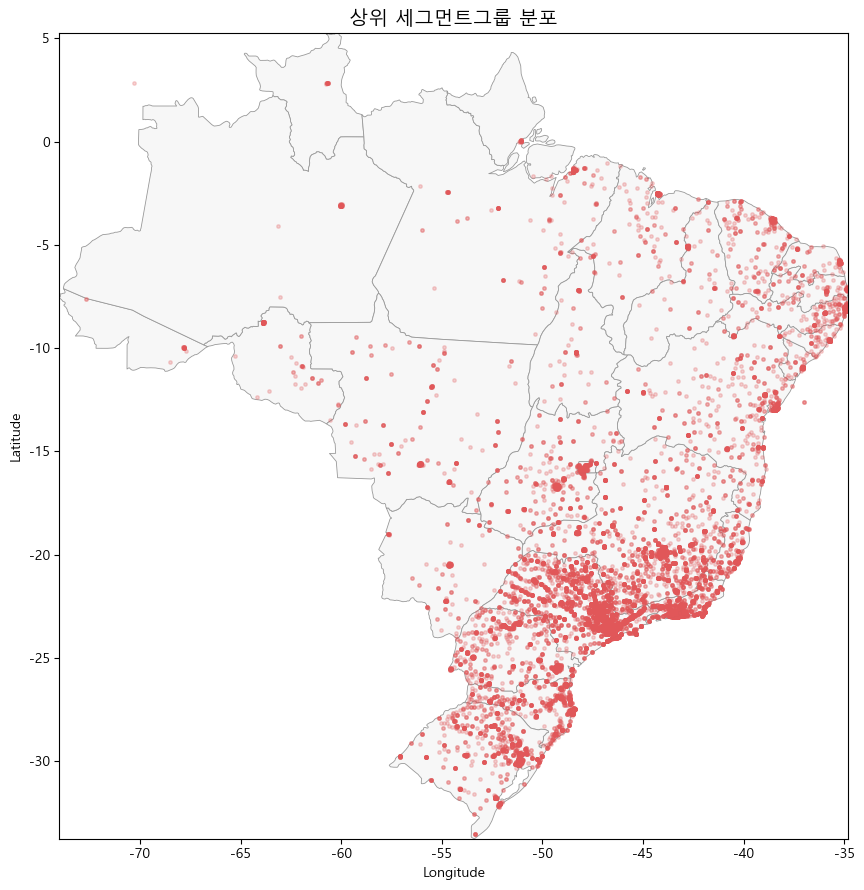

In [21]:
# === 블럭 7) 저장 ===
OUT_DIR = "_figs"; os.makedirs(OUT_DIR, exist_ok=True)
out_path = os.path.join(OUT_DIR, "vip_scatter_brazil.png")

fig, ax = plt.subplots(figsize=(9,9))
gdf_br_states.plot(ax=ax, facecolor="#F7F7F7", edgecolor="#999999", linewidth=0.6)
vip_points.plot(ax=ax, markersize=6, alpha=0.25, color="#E15759")
ax.set_xlabel("Longitude"); ax.set_ylabel("Latitude")
ax.set_title("상위 세그먼트그룹 분포", fontsize=14)
ax.set_xlim(gdf_br_states.total_bounds[0], gdf_br_states.total_bounds[2])
ax.set_ylim(gdf_br_states.total_bounds[1], gdf_br_states.total_bounds[3])
plt.tight_layout(); plt.savefig(out_path, dpi=200)
print("✓ 저장 완료:", out_path)